<a href="https://www.kaggle.com/code/owaiskhan9654/multi-label-classification-of-pubmed-articles?scriptVersionId=111566913" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>



# <p style="background-color:#1a0a36;font-family:newtimeroman;color:#FFF9ED;font-size:120%;text-align:center;border-radius:10px 10px 10px 10px;">MultiLabel Classification of PubMed Articles using Deep Learning</p>

<a href="https://www.kaggle.com/code/owaiskhan9654/multi-label-classification-of-pubmed-articles"><img src="https://raw.githubusercontent.com/Owaiskhan9654/DigiGene/main/Paper%20Night%20Design.gif"></a>


1. The traditional machine learning models give a lot of pain when we do not have sufficient labeled data for the specific task or domain we care about to train a reliable model.

2. Transfer learning allows us to deal with these scenarios by leveraging the already existing labeled data of some related task or domain. We try to store this knowledge gained in solving the source task in the source domain and apply it to our problem of interest.

3. In this work, I have utilized Transfer Learning utilizing **BIO BERT** model and Default **BERT-BASE Uncased**. 

4. Also Applied **Roberta For Sequence Classification** and **XLNet For Sequence Classification** models class for Fine-Tuning the Model. 

5. All the model performance for comparision has been logged to Weight and Biases. Check them out [here](https://wandb.ai/owaiskhan9515/Multi%20Label%20Classification%20of%20PubMed%20Articles%20(Paper%20Night%20Presentation)?workspace=) 

6. Model upload to Hugging Face Hub <img src="https://huggingface.co/front/assets/huggingface_logo-noborder.svg" style="Height: 18px;width:18px"> [Link](https://huggingface.co/owaiskha9654/Multi-Label-Classification-of-PubMed-Articles)
<br>

7. This Model has been Connected to a Live application which is Build using Gadio and runnong on HuggingFace Spaces. All the code used to make it live is present in this notebook only:). Check it out [here](https://huggingface.co/spaces/owaiskha9654/Multi-Label-Classification-of-Pubmed-Articles)

 <a id='top'></a>
 <div class="list-group" id="list-tab" role="tablist">
 <p style="background-color:#1a0a36;font-family:newtimeroman;color:#FFF9ED;font-size:200%;text-align:center;border-radius:10px 10px;">TABLE OF CONTENTS</p>   
    
* [1. IMPORTING LIBRARIES](#1)
    
* [2. LOADING DATA](#2)
    
* [3. DATA VISUALIZATION](#3)
    
* [4. Tokenizations](#4)   
    
* [5. Creating the Data Loaders](#5) 
      
* [6. Loading the pretrained model](#6)
    
* [7. Training the model](#7)
    
* [8. Visualizing The results](#8)  
    
* [9. Evaluating the model](#9)
    
* [10. Classification Report](#10)
    
* [11. References](#11)


<center><h1 style = "font-size:25px;font-family: Comic Sans MS"> Firstly installing the Transformers Library and GitHub Large file system to push code to GitHub and Model to Huggingface Platform </h1></center>




- [GitHub Code Link](https://github.com/Owaiskhan9654/Multi-Label-Classification-of-Pubmed-Articles) 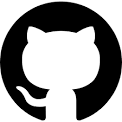 


- [Model Link](https://huggingface.co/owaiskha9654/Multi-Label-Classification-of-PubMed-Articles)<img src="https://huggingface.co/front/assets/huggingface_logo-noborder.svg" style="Height: 45px;width:45px"> 


In [1]:
! pip install -q transformers
!pip install -q gradio
!sudo apt-get install git-lfs
!git lfs install




The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 3316 kB of archives.
After this operation, 11.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 git-lfs amd64 2.9.2-1 [3316 kB]
Fetched 3316 kB in 1s (2270 kB/s)
Selecting previously unselected package git-lfs.
(Reading database ... 108264 files and directories currently installed.)
Preparing to unpack .../git-lfs_2.9.2-1_amd64.deb ...
Unpacking git-lfs (2.9.2-1) ...
Setting up git-lfs (2.9.2-1) ...
Processing triggers for man-db (2.9.1-1) ...
Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.


<a id="1"></a>
## <p style="background-color:#1a0a36;font-family:newtimeroman;color:#FFF9ED;font-size:140%;text-align:center;border-radius:10px 10px;">IMPORTING LIBRARIES</p>
#### [Top ↑](#top)

In [2]:
import os
import wandb
import torch
import pickle
import numpy as np
%matplotlib inline
import pandas as pd
import gradio as gr
import seaborn as sns
import tensorflow as tf
from typing import Dict
from ast import literal_eval
from torch.optim import AdamW
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from kaggle_secrets import UserSecretsClient
from torch.nn import BCEWithLogitsLoss, BCELoss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
from transformers import XLNetForSequenceClassification, XLNetTokenizer,BertForSequenceClassification,BertTokenizer, RobertaForSequenceClassification,RobertaTokenizer

# pd.set_option('Display.max_colwidth',None)

In [3]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [4]:
torch.__version__

'1.11.0'

In [5]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2022-11-20 16:35:46.977421: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-20 16:35:47.049930: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 16:35:47.051144: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 16:35:47.051881: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'


<img src="https://camo.githubusercontent.com/dd842f7b0be57140e68b2ab9cb007992acd131c48284eaf6b1aca758bfea358b/68747470733a2f2f692e696d6775722e636f6d2f52557469567a482e706e67">

> I will be integrating W&B for visualizations and logging artifacts and comparisons of different models!
> 
> [Multi Label Classification of PubMed Articles (Paper Night Presentation)]
> https://wandb.ai/owaiskhan9515/Multi%20Label%20Classification%20of%20PubMed%20Articles%20(Paper%20Night%20Presentation)


> 
> - To get the API key, create an account in the [website](https://wandb.ai/site) .
> - Use secrets to use API Keys more securely 

In [7]:
try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    secret_value_0 = user_secrets.get_secret("wandb_api")
    wandb.login(key=secret_value_0)
    anony=None
except:
    anony = "must"
    print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')
    
    
    
wandb.init(project="Multi Label Classification of PubMed Articles (Paper Night Presentation)",name=f"31.Biobert-base-cased-v1.2-Run-1")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: owaiskhan9515. Use `wandb login --relogin` to force relogin


<a id="2"></a>
## <p style="background-color:#1a0a36;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;"> Reading BioASQ Processed Dataset</p>
#### [Top ↑](#top)

In [8]:
dataset_Name='../input/pubmed-multilabel-text-classification/PubMed Multi Label Text Classification Dataset Processed.csv'

df= pd.read_csv(dataset_Name)
df.head(3)

,Title,abstractText,meshMajor,pmid,meshid,meshroot,A,B,C,D,E,F,G,H,I,J,L,M,N,Z
0,Expression of p53 and coexistence of HPV in pr...,Fifty-four paraffin embedded tissue sections f...,"['DNA Probes, HPV', 'DNA, Viral', 'Female', 'H...",8549602,"[['D13.444.600.223.555', 'D27.505.259.750.600....","['Chemicals and Drugs [D]', 'Organisms [B]', '...",0,1,1,1,1,0,0,1,0,0,0,0,0,0
1,Vitamin D status in pregnant Indian women acro...,The present cross-sectional study was conducte...,"['Adult', 'Alkaline Phosphatase', 'Breast Feed...",21736816,"[['M01.060.116'], ['D08.811.277.352.650.035'],...","['Named Groups [M]', 'Chemicals and Drugs [D]'...",0,1,1,1,1,1,1,0,1,1,0,1,1,1
2,[Identification of a functionally important di...,The occurrence of individual amino acids and d...,"['Amino Acid Sequence', 'Analgesics, Opioid', ...",19060934,"[['G02.111.570.060', 'L01.453.245.667.060'], [...","['Phenomena and Processes [G]', 'Information S...",1,1,0,1,1,0,1,0,0,0,1,0,0,0


In [9]:
print("Total number of Articles extracted from Bioasq dataset are =",len(df))

Total number of Articles extracted from Bioasq dataset are = 50000


In [10]:
print('Average Article length: ', df.abstractText.str.split().str.len().mean())
print('Stdev Article length: ', df.abstractText.str.split().str.len().std())

Average Article length:  192.05284
Stdev Article length:  76.74764082329723


In [11]:
cols = df.columns
cols = list(df.columns)
mesh_Heading_categories = cols[6:]
num_labels = len(mesh_Heading_categories)
print('Mesh Labels Root Class: "\n"',mesh_Heading_categories)
print("\n")
print('Number of Labels: ' ,num_labels)


Mesh Labels Root Class: "
" ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'Z']


Number of Labels:  14


Orginal Version of this Dataset contains **15,559,157 Articles** from [BioASQ Task 9A](http://participants-area.bioasq.org/datasets/).
More details about the format of the data and the task are available in the [Guidelines for task 9a](http://participants-area.bioasq.org/general_information/Task9a/)

This dataset which I am using currently is a preprocessed version and currently consists of a approx **50k** collection of research articles from [**PubMed**](https://pubmed.ncbi.nlm.nih.gov/) repository. Originally these documents are manually annotated by Biomedical Experts with their MeSH labels and each articles are described in terms of 10-15 MeSH labels. In this Dataset we have huge numbers of labels present as a MeSH major which is raising the issue of extremely large output space and severe label sparsity issues. To solve this Issue Dataset has been Processed and mapped to its root as Described in the Below Figure.
![Mapped Image not Fetched](https://raw.githubusercontent.com/Owaiskhan9654/Gene-Sequence-Primer-/main/Capture111.PNG)
![Tree Structure](https://raw.githubusercontent.com/Owaiskhan9654/Gene-Sequence-Primer-/main/Capture22.PNG)




For more information on the attributes visit [here](https://www.kaggle.com/datasets/owaiskhan9654/pubmed-multilabel-text-classification).

<a id="3"></a>
## <p style="background-color:#1a0a36;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:5px 5px;">DATA VISUALIZATION</p>
#### [Top ↑](#top)

#### In order to, get a full grasp of what steps should I be taking to utilizing this dataset. Let us have a look at the information in data. 

In [12]:
%%time

counts = []
for mesh_Heading_category in mesh_Heading_categories:
    counts.append((mesh_Heading_category, df[mesh_Heading_category].sum()))
df_count = pd.DataFrame(counts, columns=['Root Label', 'number of Abstract'])
df_count

CPU times: user 5.74 ms, sys: 189 µs, total: 5.93 ms
Wall time: 5.52 ms


,Root Label,number of Abstract
0,A,23263
1,B,46577
2,C,26453
3,D,31074
4,E,39202
5,F,8885
6,G,33609
7,H,6069
8,I,5595
9,J,5531


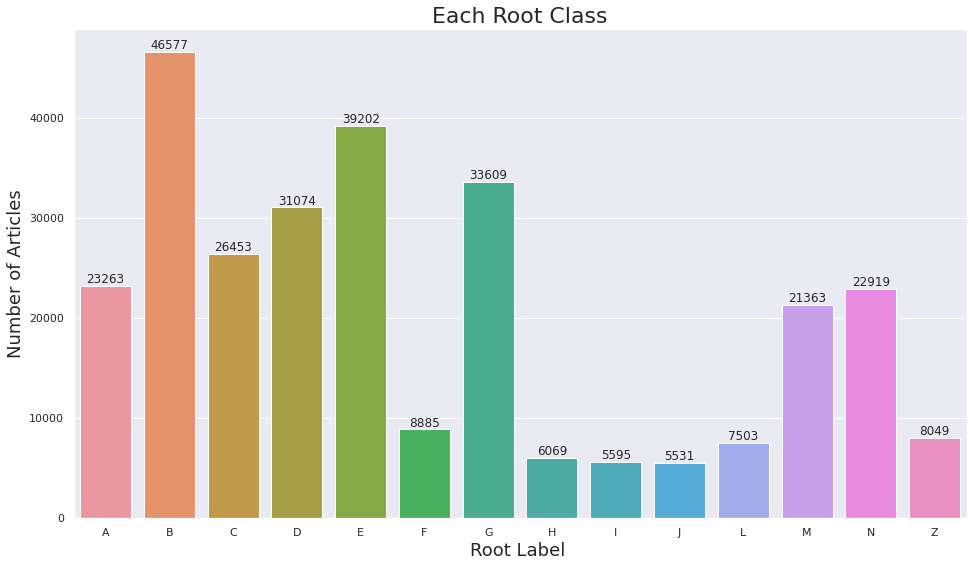

CPU times: user 594 ms, sys: 113 ms, total: 707 ms
Wall time: 592 ms


In [13]:
%%time
sns.set(font_scale = 1)
plt.figure(figsize=(16,9))
ax= sns.barplot(mesh_Heading_categories, df.iloc[:,6:].sum().values)
plt.title("Each Root Class", fontsize=22)
plt.ylabel('Number of Articles', fontsize=18)
plt.xlabel('Root Label ', fontsize=18)

#adding the text labels
rects = ax.patches
labels = df.iloc[:,6:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=12)

plt.show()

In [14]:
df_train, df_test = train_test_split(df, random_state=32, test_size=0.20, shuffle=True)

print(df_train.shape)
print(df_test.shape)
del(df)

(40000, 20)
(10000, 20)


In [15]:
df_train['one_hot_labels'] = list(df_train[mesh_Heading_categories].values)
df_train.head(3)

,Title,abstractText,meshMajor,pmid,meshid,meshroot,A,B,C,D,...,F,G,H,I,J,L,M,N,Z,one_hot_labels
31112,Neurofibromatosis associated with a coronary a...,A case of a patient with type 1 neurofibromato...,"['Aged', 'Coronary Aneurysm', 'Humans', 'Male'...",11144803,"[['M01.060.116.100'], ['C14.280.647.250.250', ...","['Named Groups [M]', 'Diseases [C]', 'Organism...",0,1,1,0,...,0,0,0,0,0,0,1,0,0,"[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
48911,Phenolic constituents from Perovskia atriplici...,"Perovskoate, an isorinic acid derivative (1) a...","['Caffeic Acids', 'Catechols', 'Cholinesterase...",16644529,"[['D02.241.223.200.054'], ['D02.455.426.559.38...","['Chemicals and Drugs [D]', 'Analytical, Diagn...",0,1,0,1,...,0,1,0,0,0,0,0,0,0,"[0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
16394,Motion artifact and background noise suppressi...,Optical coherence tomography (OCT) is a techni...,"['Algorithms', 'Angiography', 'Artifacts', 'Ar...",25089975,"[['G17.035', 'L01.224.050'], ['E01.370.350.700...","['Phenomena and Processes [G]', 'Information S...",0,0,0,0,...,0,1,0,0,0,1,0,1,0,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]"


In [16]:
labels = list(df_train.one_hot_labels.values)
Article_train = list(df_train.abstractText.values)

<a id="4"></a>
## <p style="background-color:#1a0a36;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;"> Tokenizations</p>
#### [Top ↑](#top)

In [17]:
%%time
max_length = 128
#tokenizer = RobertaTokenizer.from_pretrained('distilroberta-base', do_lower_case=False)  # tokenizer
tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.2', do_lower_case=True) 
#tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=False) 

encodings = tokenizer.batch_encode_plus(Article_train,max_length=max_length,padding=True,truncation=True) # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

input_ids = encodings['input_ids'] # tokenized and encoded sentences
attention_masks = encodings['attention_mask'] # attention masks

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

tokenizer outputs:  dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
CPU times: user 4min 22s, sys: 799 ms, total: 4min 23s
Wall time: 4min 26s


In [18]:
# Identifying indices of 'one_hot_labels' entries that only occur once - this will allow me to stratify split our training data later
label_counts = df_train.one_hot_labels.astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(df_train[df_train.one_hot_labels.astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq_idxs)

df label indices with only one instance:  [49950, 49878, 49876, 49838, 49759, 49739, 49696, 49590, 49585, 49574, 49546, 49535, 49528, 49487, 49470, 49419, 49404, 49395, 49314, 49245, 49150, 49080, 49071, 49058, 49004, 48991, 48982, 48922, 48919, 48757, 48708, 48686, 48679, 48677, 48602, 48594, 48583, 48531, 48454, 48438, 48411, 48388, 48375, 48350, 48337, 48298, 48213, 48185, 48123, 48085, 48075, 48056, 48020, 48001, 47876, 47840, 47828, 47817, 47776, 47671, 47495, 47435, 47369, 47363, 47362, 47359, 47356, 47321, 47293, 47244, 47239, 47159, 47104, 47089, 47061, 47050, 47002, 46955, 46887, 46874, 46837, 46747, 46706, 46651, 46635, 46598, 46446, 46365, 46247, 46223, 46199, 46170, 46033, 46028, 45955, 45946, 45756, 45755, 45712, 45682, 45671, 45573, 45509, 45430, 45391, 45317, 45294, 45226, 45216, 45190, 45134, 45132, 45105, 45052, 45035, 45025, 44971, 44953, 44867, 44851, 44827, 44777, 44763, 44625, 44606, 44598, 44586, 44579, 44574, 44568, 44499, 44479, 44462, 44296, 44206, 44181, 44116

In [19]:

train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
                                                            random_state=2020, test_size=0.20)

# Convert all of our data into torch tensors, the required datatype for our BERT Pytorch model
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:207.)
  


<a id="5"></a>
## <p style="background-color:#1a0a36;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;"> Creating the Data Loaders</p>
#### [Top ↑](#top)

In [20]:
batch_size = 64

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data =     TensorDataset(train_inputs, train_masks, train_labels,)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels,)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [21]:
torch.save(validation_dataloader,'validation_data_loader')
torch.save(train_dataloader,'train_data_loader')

<a id="6"></a>
## <p style="background-color:#1a0a36;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;"> Loading the pretrained model</p>
#### [Top ↑](#top)

In [22]:
%%time
#Tried Several Models Locally XLNet was performing Best. Note If you are changing the model then change the Tokenizer also
# model = RobertaForSequenceClassification.from_pretrained('distilroberta-base', num_labels=num_labels)
model = BertForSequenceClassification.from_pretrained("dmis-lab/biobert-base-cased-v1.2", num_labels=num_labels)
# model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=num_labels)
model.cuda()
print('Model Pushed to Cuda for Training')

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.2 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

Model Pushed to Cuda for Training
CPU times: user 8.98 s, sys: 1.69 s, total: 10.7 s
Wall time: 22.7 s


In [23]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [24]:
optimizer = AdamW(optimizer_grouped_parameters,lr=6e-6)
# optimizer = AdamW(model.parameters(),lr=4e-5)  # Default optimization #XL-NET

In [25]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH']='true'

<a id="7"></a>
## <p style="background-color:#1a0a36;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;"> Training the model</p>
#### [Top ↑](#top)

In [26]:
%%time

# For Storing our loss and accuracy for plotting
train_loss_set = []
val_f1_accuracy_list,val_flat_accuracy_list,training_loss_list,epochs_list=[],[],[],[]

# Number of training epochs (Orignal author's recommend between 10 and 20)
epochs = 12

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch "):
    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0 #running loss
    nb_tr_examples, nb_tr_steps = 0, 0
  
    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels= batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()

        # Forward pass for multilabel classification
        # https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss
        # Creates a criterion that measures the Binary Cross Entropy between the target and the input probabilities
        # Also This loss combines a Sigmoid layer and the BCELoss in one single class. This version is more numerically stable 
        # than using a plain Sigmoid followed by a BCELoss as, by combining the operations into one layer, we take advantage of the 
        # log-sum-exp trick for numerical stability.
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs[0]
        loss_func = BCEWithLogitsLoss() 
        loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
        
        train_loss_set.append(loss.item())    

        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # scheduler.step()
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    training_loss_list.append(tr_loss/nb_tr_steps)

    ###############################################################################

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Variables to gather full output
    logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

    # Predict
    for i, batch in enumerate(validation_dataloader):
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            # Forward pass
            outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            b_logit_pred = outs[0]
            pred_label = torch.sigmoid(b_logit_pred)

        b_logit_pred = b_logit_pred.detach().cpu().numpy()
        pred_label = pred_label.to('cpu').numpy()
        b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

    # Flatten outputs
    pred_labels = [item for sublist in pred_labels for item in sublist]
    true_labels = [item for sublist in true_labels for item in sublist]

    # Calculate Accuracy
    threshold = 0.50
    pred_bools = [pl>threshold for pl in pred_labels]
    true_bools = [tl==1 for tl in true_labels]
    val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
    val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

    print('F1 Validation Accuracy: ', val_f1_accuracy)  
    print('Flat Validation Accuracy: ', val_flat_accuracy)
    print('\n')
    val_f1_accuracy_list.append(val_f1_accuracy)
    val_flat_accuracy_list.append(val_flat_accuracy)
    epochs_list.append(epochs)  
    
    wandb.log({"train_loss":tr_loss/nb_tr_steps,"val_f1_accuracy":val_f1_accuracy,"val_flat_accuracy":val_flat_accuracy,})
wandb.finish()

Epoch :   0%|          | 0/12 [00:00<?, ?it/s]

Train loss: 0.4239188883304596


Epoch :   8%|▊         | 1/12 [06:11<1:08:02, 371.10s/it]

F1 Validation Accuracy:  82.86516853932585
Flat Validation Accuracy:  7.8125


Train loss: 0.32975323355197905


Epoch :  17%|█▋        | 2/12 [12:21<1:01:47, 370.72s/it]

F1 Validation Accuracy:  85.79310344827586
Flat Validation Accuracy:  17.1875


Train loss: 0.3026079798936844


Epoch :  25%|██▌       | 3/12 [18:32<55:36, 370.69s/it]  

F1 Validation Accuracy:  87.25761772853186
Flat Validation Accuracy:  21.875


Train loss: 0.28560216721892356


Epoch :  33%|███▎      | 4/12 [24:43<49:25, 370.73s/it]

F1 Validation Accuracy:  86.8238557558946
Flat Validation Accuracy:  18.75


Train loss: 0.2731225632429123


Epoch :  42%|████▏     | 5/12 [30:53<43:15, 370.73s/it]

F1 Validation Accuracy:  87.25761772853186
Flat Validation Accuracy:  21.875


Train loss: 0.26177653047442434


Epoch :  50%|█████     | 6/12 [37:04<37:04, 370.71s/it]

F1 Validation Accuracy:  85.98901098901099
Flat Validation Accuracy:  15.625


Train loss: 0.2515459747314453


Epoch :  58%|█████▊    | 7/12 [43:15<30:53, 370.73s/it]

F1 Validation Accuracy:  86.70360110803324
Flat Validation Accuracy:  20.3125


Train loss: 0.2412676520049572


Epoch :  67%|██████▋   | 8/12 [49:26<24:43, 370.82s/it]

F1 Validation Accuracy:  86.67601683029453
Flat Validation Accuracy:  20.3125


Train loss: 0.23114648947119712


Epoch :  75%|███████▌  | 9/12 [55:37<18:32, 370.83s/it]

F1 Validation Accuracy:  86.2258953168044
Flat Validation Accuracy:  18.75


Train loss: 0.2214344907104969


Epoch :  83%|████████▎ | 10/12 [1:01:48<12:21, 370.89s/it]

F1 Validation Accuracy:  85.87257617728531
Flat Validation Accuracy:  21.875


Train loss: 0.21113203698396682


Epoch :  92%|█████████▏| 11/12 [1:07:59<06:10, 370.98s/it]

F1 Validation Accuracy:  86.41975308641976
Flat Validation Accuracy:  18.75


Train loss: 0.20146742707490922


Epoch : 100%|██████████| 12/12 [1:14:10<00:00, 370.88s/it]

F1 Validation Accuracy:  85.75380359612724
Flat Validation Accuracy:  17.1875




train_loss,█▅▄▄▃▃▃▂▂▂▁▁
val_f1_accuracy,▁▆█▇█▆▇▇▆▆▇▆
val_flat_accuracy,▁▆█▆█▅▇▇▆█▆▆
train_loss,0.20147
val_f1_accuracy,85.7538
val_flat_accuracy,17.1875


CPU times: user 1h 13min 50s, sys: 8 s, total: 1h 13min 58s
Wall time: 1h 14min 14s


In [27]:
num_epochs = np.arange(1,len(training_loss_list)+1)
df_train_results=pd.DataFrame({'Epochs':num_epochs,'F1 Validation Accuracy':val_f1_accuracy_list,\
                               'Flat Validation Accuracy':val_flat_accuracy_list,'Train loss':training_loss_list})

<a id="8"></a>
## <p style="background-color:#1a0a36;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;"> Visualizing The results</p>

#### [Top ↑](#top)

Text(0.5, 1.0, 'Training Loss vs Number of Epochs for Bert-Base')

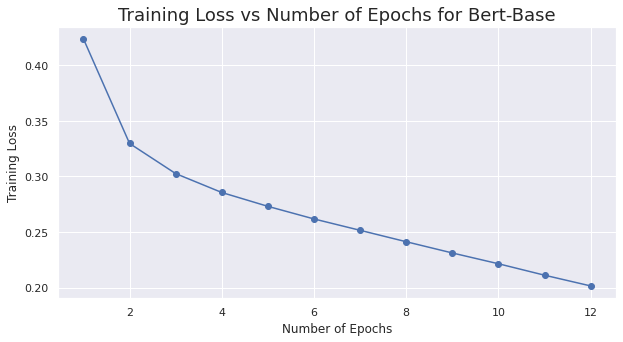

In [28]:
fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(training_loss_list) ,'bo-',label="Train Loss")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Training Loss")
ax.set_title("Training Loss vs Number of Epochs for Bert-Base",fontsize=18)

(0.0, 100.0)

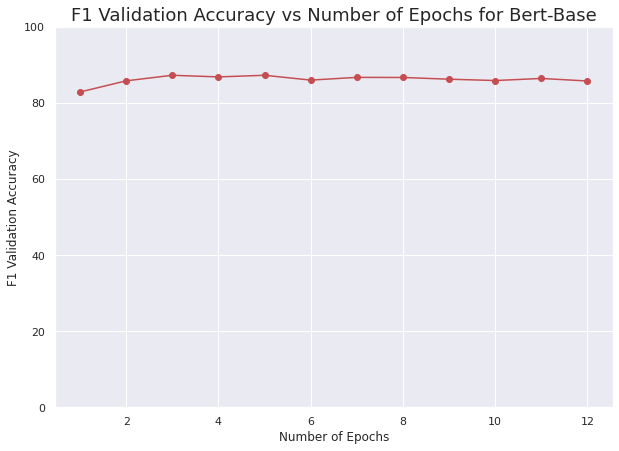

In [29]:
fig, ax = plt.subplots(figsize=(10, 7));
ax.plot(num_epochs, np.array(val_f1_accuracy_list),'ro-' ,label="F1 Validation Accuracy")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("F1 Validation Accuracy")
ax.set_title("F1 Validation Accuracy vs Number of Epochs for Bert-Base",fontsize=18)
ax.set_ylim(0, 100)

(0.0, 100.0)

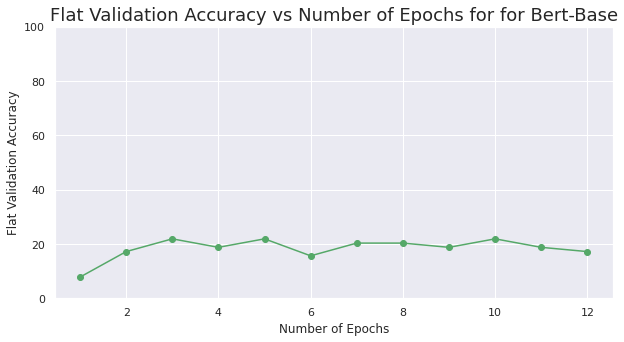

In [30]:
fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(val_flat_accuracy_list),'go-', label="Flat Validation Accuracy")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Flat Validation Accuracy")
ax.set_title("Flat Validation Accuracy vs Number of Epochs for for Bert-Base",fontsize=18)
ax.set_ylim(0, 100)

In [31]:
df_test['one_hot_labels'] = list(df_test[mesh_Heading_categories].values)
df_test.head(3)

,Title,abstractText,meshMajor,pmid,meshid,meshroot,A,B,C,D,...,F,G,H,I,J,L,M,N,Z,one_hot_labels
35083,Expression of N-methyl-d-aspartate receptor 1 ...,High levels of glutamate can be toxic to retin...,"['Analysis of Variance', 'Animals', 'Cell Deat...",17942238,"[['E05.318.740.150', 'N05.715.360.750.125', 'N...","['Analytical, Diagnostic and Therapeutic Techn...",1,1,1,1,...,0,1,0,0,0,0,0,1,0,"[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]"
9005,Protection of pregnant swine by vaccination ag...,The protection conferred on pregnant gilts by ...,"['Animals', 'Antibodies, Bacterial', 'Bacteria...",7150130,"[['B01.050'], ['D12.776.124.486.485.114.107', ...","['Organisms [B]', 'Chemicals and Drugs [D]', '...",0,1,1,1,...,0,1,0,0,0,0,0,1,0,"[0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]"
23836,An examination of Escherichia coli strains iso...,Ninety-five strains of Escherichia coli isolat...,"['Animals', 'Antigens', 'Antigens, Bacterial',...",6135266,"[['B01.050'], ['D23.050'], ['D23.050.161'], ['...","['Organisms [B]', 'Chemicals and Drugs [D]', '...",1,1,1,1,...,0,1,0,0,0,0,0,0,0,"[1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"


In [32]:
test_labels = list(df_test.one_hot_labels.values)
Articles_test = list(df_test.abstractText.values)
test_mesh_categories = list(df_test.columns[6:20])

In [33]:
# Encoding input data
test_encodings = tokenizer.batch_encode_plus(Articles_test,max_length=max_length,padding=True,truncation=True)
test_input_ids = test_encodings['input_ids']
test_attention_masks = test_encodings['attention_mask']

In [34]:
# Make tensors out of data
test_inputs = torch.tensor(test_input_ids)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_attention_masks)
# Create test dataloader
test_data = TensorDataset(test_inputs, test_masks, test_labels,)# test_token_types)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
# Save test dataloader
torch.save(test_dataloader,'test_data_loader')

<a id="9"></a>
## <p style="background-color:#1a0a36;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;"> Evaluating the model</p>
#### [Top ↑](#top) 

In [35]:
%%time

# Test

# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

#track variables
logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

# Predict
for i, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, = batch
    with torch.no_grad():
        # Forward pass
        outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        b_logit_pred = outs[0]
        pred_label = torch.sigmoid(b_logit_pred)

        b_logit_pred = b_logit_pred.detach().cpu().numpy()
        pred_label = pred_label.to('cpu').numpy()
        b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

# Flatten outputs
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]
# Converting flattened binary values to boolean values
true_bools = [tl==1 for tl in true_labels]

CPU times: user 35 s, sys: 30.9 ms, total: 35 s
Wall time: 35.1 s


<a id="10"></a>
## <p style="background-color:#1a0a36;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;"> Classification Report</p>
#### [Top ↑](#top)


In [36]:
pred_bools = [pl>0.50 for pl in pred_labels] #boolean output after thresholding
# Print and save classification report
Test_F1_Accuracy=f1_score(true_bools, pred_bools,average='micro')
Test_Flat_Accuracy= accuracy_score(true_bools, pred_bools)
print('Test F1 Accuracy: ',Test_F1_Accuracy )
print('Test Flat Accuracy: ',Test_Flat_Accuracy,'\n')

df_test=pd.DataFrame({'Test F1 Accuracy':Test_F1_Accuracy, 'Test Flat Accuracy':Test_Flat_Accuracy},index=[0])

print(classification_report(true_bools,pred_bools,target_names=test_mesh_categories))
clf_report = classification_report(true_bools,pred_bools,target_names=test_mesh_categories,output_dict=True)
df_report=pd.DataFrame(clf_report).transpose()



Test F1 Accuracy:  0.8500190297483647
Test Flat Accuracy:  0.1688 

              precision    recall  f1-score   support

           A       0.78      0.82      0.80      4609
           B       0.97      0.98      0.97      9250
           C       0.88      0.87      0.87      5206
           D       0.92      0.92      0.92      6259
           E       0.84      0.89      0.86      7778
           F       0.82      0.74      0.78      1767
           G       0.85      0.87      0.86      6799
           H       0.57      0.21      0.31      1221
           I       0.67      0.65      0.66      1068
           J       0.71      0.59      0.64      1110
           L       0.71      0.44      0.55      1491
           M       0.87      0.90      0.88      4232
           N       0.82      0.78      0.80      4602
           Z       0.73      0.68      0.71      1558

   micro avg       0.86      0.84      0.85     56950
   macro avg       0.79      0.74      0.76     56950
weighted avg

In [37]:
df_report.to_csv('Classification_Report.csv',index=False)

In [38]:
model.save_pretrained('./Multi_label_Classification_Save/')
tokenizer.save_pretrained('./Multi_label_Classification_Save/')

('./Multi_label_Classification_Save/tokenizer_config.json',
 './Multi_label_Classification_Save/special_tokens_map.json',
 './Multi_label_Classification_Save/vocab.txt',
 './Multi_label_Classification_Save/added_tokens.json')

In [39]:
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("Hugging_Face_model_Push_Secret") ##Has kept it private. Please use your own token

In [40]:
#Converting Labels to categorical before pushing it to Hugging Face Hub
model.config.label2id= {
"Anatomy [A]": 0,
"Organisms [B]": 1,
"Diseases [C]": 2,
"Chemicals and Drugs [D]": 3,
"Analytical, Diagnostic and Therapeutic Techniques, and Equipment [E]": 4,
"Psychiatry and Psychology [F]": 5,
"Phenomena and Processes [G]": 6,
"Disciplines and Occupations [H]": 7,
"Anthropology, Education, Sociology, and Social Phenomena [I]": 8,
"Technology, Industry, and Agriculture [J]": 9,
"Information Science [L]": 10,
"Named Groups [M]": 11,
"Health Care [N]": 12,
"Geographicals [Z]": 13,
}


model.config.id2label={
    "0": "Anatomy [A]",
    "1": "Organisms [B]",
    "2": "Diseases [C]",
    "3": "Chemicals and Drugs [D]",
    "4": "Analytical, Diagnostic and Therapeutic Techniques, and Equipment [E]",
    "5": "Psychiatry and Psychology [F]",
    "6": "Phenomena and Processes [G]",
    "7": "Disciplines and Occupations [H]",
    "8": "Anthropology, Education, Sociology, and Social Phenomena [I]",
    "9": "Technology, Industry, and Agriculture [J]",
    "10": "Information Science [L]",
    "11": "Named Groups [M]",
    "12": "Health Care [N]",
    "13": "Geographicals [Z]"
}
    

In [41]:
model.push_to_hub(repo_path_or_name='owaiskha9654/Multi-Label-Classification-of-PubMed-Articles',use_auth_token=secret_value_0)

Cloning https://huggingface.co/owaiskha9654/Multi-Label-Classification-of-PubMed-Articles into local empty directory.


Download file pytorch_model.bin:   0%|          | 8.00k/413M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/413M [00:00<?, ?B/s]

Download file pytorch_model.bin:   0%|          | 32.0k/413M [00:00<?, ?B/s]

Upload file pytorch_model.bin:   0%|          | 32.0k/413M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/owaiskha9654/Multi-Label-Classification-of-PubMed-Articles
   c3f84ab..e420366  main -> main



'https://huggingface.co/owaiskha9654/Multi-Label-Classification-of-PubMed-Articles/commit/e42036624036f19f8f0453e3cdac1370d1d75f4b'

In [42]:
tokenizer.push_to_hub(repo_path_or_name='owaiskha9654/Multi-Label-Classification-of-PubMed-Articles',use_auth_token=secret_value_0)

In [43]:
tokenizer = BertTokenizer.from_pretrained('owaiskha9654/Multi-Label-Classification-of-PubMed-Articles', do_lower_case=True) 


In [44]:
num_labels=14
model = BertForSequenceClassification.from_pretrained("owaiskha9654/Multi-Label-Classification-of-PubMed-Articles", num_labels=num_labels)

In [45]:
def Multi_Label_Classification_of_Pubmed_Articles(model_input: str) -> Dict[str, float]:
    
    # Encoding input data
    dict_custom={}
    Preprocess_part1=model_input[:len(model_input)]
    Preprocess_part2=model_input[len(model_input):]
    dict1=tokenizer.encode_plus(Preprocess_part1,max_length=1024,padding=True,truncation=True)
    dict2=tokenizer.encode_plus(Preprocess_part2,max_length=1024,padding=True,truncation=True)
    
    dict_custom['input_ids']=[dict1['input_ids'],dict1['input_ids']]
    dict_custom['token_type_ids']=[dict1['token_type_ids'],dict1['token_type_ids']]
    dict_custom['attention_mask']=[dict1['attention_mask'],dict1['attention_mask']]
    
    outs = model(torch.tensor(dict_custom['input_ids']), token_type_ids=None, attention_mask=torch.tensor(dict_custom['attention_mask']))
    b_logit_pred = outs[0]
    pred_label = torch.sigmoid(b_logit_pred)
    
    ret ={
        "Anatomy [A]": float(pred_label[0][0]),
        "Organisms [B]": float(pred_label[0][1]),
        "Diseases [C]": float(pred_label[0][2]),
        "Chemicals and Drugs [D]": float(pred_label[0][3]),
        "Analytical, Diagnostic and Therapeutic Techniques, and Equipment [E]": float(pred_label[0][4]),
        "Psychiatry and Psychology [F]": float(pred_label[0][5]),
        "Phenomena and Processes [G]": float(pred_label[0][6]),
        "Disciplines and Occupations [H]": float(pred_label[0][7]),
        "Anthropology, Education, Sociology, and Social Phenomena [I]": float(pred_label[0][8]),
        "Technology, Industry, and Agriculture [J]": float(pred_label[0][9]),
        "Information Science [L]": float(pred_label[0][10]),
        "Named Groups [M]": float(pred_label[0][11]),
        "Health Care [N]": float(pred_label[0][12]),
        "Geographicals [Z]": float(pred_label[0][13])}
    return ret


model_input = gr.Textbox("Input text here (Note: This model is trained to classify Medical Articles(Still in Progress phase))", show_label=False)
model_output = gr.Label("Multi Label MeSH(Medical Subheadings) Result", num_top_classes=6, show_label=True, label="MeSH(Medical Subheadings) Labels assigned to this article")


examples = [
    (
        "A case of a patient with type 1 neurofibromatosis associated with popliteal and coronary artery aneurysms is described in which cross-sectional",
        "imaging provided diagnostic information.",
        "The aim of this study was to compare the exercise intensity and competition load during Time Trial (TT), Flat (FL), Medium Mountain (MM) and High ",
        "Mountain (HM) stages based heart rate (HR) and session rating of perceived exertion (RPE).METHODS: We monitored both HR and RPE of 12 professional ",
        "cyclists during two consecutive 21-day cycling races in order to analyze the exercise intensity and competition load (TRIMPHR and TRIMPRPE).",
        "RESULTS:The highest (P<0.05) mean HR was found in TT (169±2 bpm) versus those observed in FL (135±1 bpm), MM (139±3 bpm), HM (143±1 bpm)"
    ),
    (
        "The association of body mass index (BMI) with blood pressure may be stronger in Asian than non-Asian populations, however, longitudinal studies ",
        "with direct comparisons between ethnicities are lacking. We compared the relationship of BMI with incident hypertension over approximately 9.5 years",
        " of follow-up in young (24-39 years) and middle-aged (45-64 years) Chinese Asians (n=5354), American Blacks (n=6076) and American Whites (n=13451).",
        "We estimated risk differences using logistic regression models and calculated adjusted incidences and incidence differences. ",
        "To facilitate comparisons across ethnicities, standardized estimates were calculated using mean covariate values for age, sex, smoking, education",
        "and field center, and included the quadratic terms for BMI and age. Weighted least-squares regression models with were constructed to summarize",
        "ethnic-specific incidence differences across BMI. Wald statistics and p-values were calculated based on chi-square distributions. The association of",
        "BMI with the incidence difference for hypertension was steeper in Chinese (p<0.05) than in American populations during young and middle-adulthood.",
        "For example, at a BMI of 25 vs 21 kg/m2 the adjusted incidence differences per 1000 persons (95% CI) in young adults with a BMI of 25 vs those with",
        "a BMI of 21 was 83 (36- 130) for Chinese, 50 (26-74) for Blacks and 30 (12-48) for Whites"
    )
]

title = "Multi Label Classification of Pubmed Articles (Paper Night July Edition at Thoucentric)"
description = "The traditional machine learning models give a lot of pain when we do not have sufficient labeled data for the specific task or domain we care about to train a reliable model. Transfer learning allows us to deal with these scenarios by leveraging the already existing labeled data of some related task or domain. We try to store this knowledge gained in solving the source task in the source domain and apply it to our problem of interest. In this work, I have utilized Transfer Learning utilizing BIO BERT model to fine tune on Pubmed MultiLabel classification Dataset."
text1 = (
    "<center> Author: Owais Ahmad Data Scientist at <b> Thoucentric </b> <a href=\"https://www.linkedin.com/in/owaiskhan9654/\">Visit Profile</a> <br></center>"
    
    "<center> Model Trained Kaggle Kernel <a href=\"https://www.kaggle.com/code/owaiskhan9654/multi-label-classification-of-pubmed-articles\">Link</a> <br></center>"
        
    "<center> Kaggle Profile <a href=\"https://www.kaggle.com/owaiskhan9654\">Link</a> <br> </center>"
    
    "<center> HuggingFace Model Deployed Repository <a href=\"https://huggingface.co/owaiskha9654/Multi-Label-Classification-of-PubMed-Articles\">Link</a> <br></center>"
)



app = gr.Interface(
    Multi_Label_Classification_of_Pubmed_Articles, 
	inputs=model_input,
    outputs=model_output, 
    examples=examples,
    title=title,
	description=description,
    article=text1,
    allow_flagging='never',
    analytics_enabled=False,
)


app.launch(inline=True,share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://e47d8525c22351de.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


<a id="11"></a>
## <p style="background-color:#1a0a36;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;"> References</p>
1. [Attention Is All You Need](https://arxiv.org/abs/1706.03762)
2. [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)
2. https://github.com/google-research/bert
3. https://github.com/huggingface/transformers
4. [BCE WITH LOGITS LOSS Pytorch](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html#torch.nn.BCEWithLogitsLoss)
5. [Transformers for Multi-Label Classification made simple by 
Ronak Patel](https://towardsdatascience.com/transformers-for-multilabel-classification-71a1a0daf5e1)




#### [Top ↑](#top)



<a href="https://thoucentric.com/"><img src="https://raw.githubusercontent.com/Owaiskhan9654/BERT-Q-A/main/Design.gif"></a>
<center><b>Visit Company website by clicking on the Logo</b></center>

<center><h1 style = "font-size:25px;font-family: Comic Sans MS">  Feel free to comment if you have any queries:)</h1></center>

<center><h1 style = "font-size:25px;font-family: Comic Sans MS">  Also currently this notebook needs lots of improvements and I am open to suggestions.</h1></center>

 ### This Notebook is Created by [**Owais Ahmad**](https://www.linkedin.com/in/owaiskhan9654/) for Multi label Classification of PubMed Articles incorporating Transfer Learning Techniques.
 ### This is for Tutorial/Research Purpose only
 
 
 
- **Email owaiskhan9654@gmail.com**
- **Contact +919515884381**